# Pré-processamento nos dados
***

### O objetivo dessa etapa do projeto é encontrar a melhor maneira de segmentação dos dados de entrada. dito isso, observaremos algumas complicações nessa etapa e soluções para elas, bem como, a conclusão de melhores técnicas de PDI para as imagens.


### Importações
***

In [1]:
import cv2                  
import numpy as np                   
import matplotlib.pyplot as plt      
import random
from scipy.signal import convolve2d
import skimage.morphology   

### Pré-processamento  nos caracteres individuais
***

#### Primeira abordagem foi utilizar técnicas de contraste e gammaCorrection para melhor segmentação dos pontos em braille (técninca essa que não possui bons resultados, pois a segmentação por histograma (que veremos um uso dela mais a frente) seria muito mais complexa. Além disso, não houve um bom desempenho com varias imagens, algumas tiveram um bom resultado, outras não.

In [2]:
img_in = cv2.imread('images/digitalizacao.jpeg',0) #Recebendo a imagem em grayescale

img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)  #Convertendo a imagem para RGB

g1 = np.zeros (img_in.shape, img_in.dtype)      #Tomando como referência as dimensões da imagem de entrada
g2 = np.zeros (img_in.shape, img_in.dtype)
g3 = np.zeros (img_in.shape, img_in.dtype)

g = img_in
#Aplicando contraste em limiares distintitos
im1= cv2.intensity_transform.contrastStretching(img_in,g1,0,255,255,0)  
im2= cv2.intensity_transform.contrastStretching(img_in,g2,10,100,0,10)
#Aplicando gammaCorrection
im3= cv2.intensity_transform.gammaCorrection(img_in,g3,16)


Text(0.5, 1.0, 'gammaCorrection: 16')

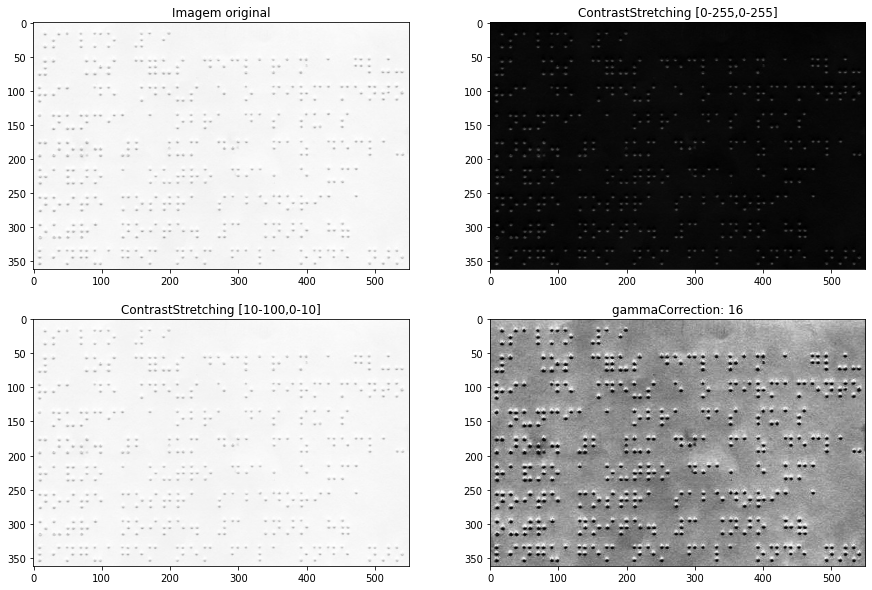

In [3]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axs[0,0].imshow(g)
axs[0,0].set_title("Imagem original", size=12)
axs[0,1].imshow(g1)
axs[0,1].set_title("ContrastStretching [0-255,0-255]",size=12)
axs[1,0].imshow(g2)
axs[1,0].set_title("ContrastStretching [10-100,0-10]",size=12)
axs[1,1].imshow(g3)
axs[1,1].set_title("gammaCorrection: 16",size=12)

#### A segunda abordagem foi o uso da binarização, através da OpenCV com o comando de threshold e oferecendo um limiar específico e aplicando THRESH_BINARY

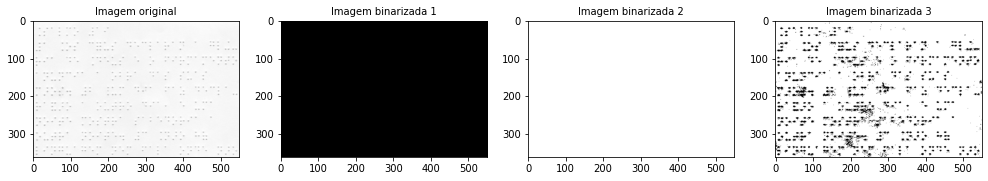

In [4]:
#Aqui é feita a binarização das imagens de entrada modificadas pelos filtros da célula anterior e a imagem de entrada
th, im_th = cv2.threshold(g1, 160, 250, cv2.THRESH_BINARY)

th, im_th2 = cv2.threshold(g, 50, 255, cv2.THRESH_BINARY)

th, im_th3 = cv2.threshold(g3, 110, 255, cv2.THRESH_BINARY)

figure, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(17, 17))
axs[0].set_title("Imagem original", size = 10)
axs[0].imshow(img_in)
axs[1].set_title("Imagem binarizada 1", size = 10)
axs[1].imshow(im_th)
axs[2].set_title("Imagem binarizada 2", size = 10)
axs[2].imshow(im_th2)
axs[3].set_title("Imagem binarizada 3", size = 10)
axs[3].imshow(im_th3)

#### Agora uma binarização apenas com a imagem de entrada por outro método de binarização:

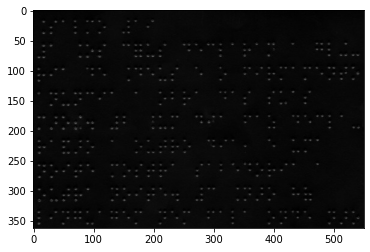

In [5]:
#Esse tipo de binarização nos tras a vantagem de não precisar oferecer um limiar para ser binarizado
bin_img = ~img_in
plt.imshow(bin_img)

#### Após a binarização foi testado os filtros para remoção de ruído da imagem de entrada, que eventualmente pode dificultar nossa identificação da imagem de entrada.

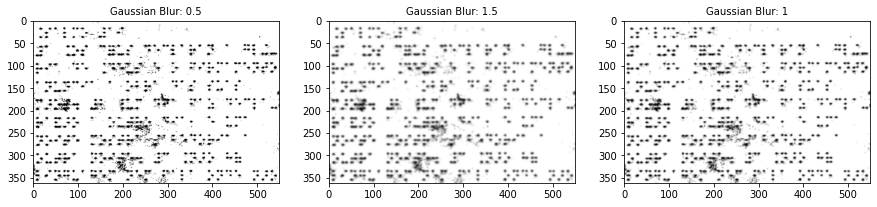

In [6]:
nsize=21
size = (nsize,nsize)

#Aplicação do filtro Gussian Blur nas imagens binarizadas com os filtros anteriormente.

im_out1 = cv2.GaussianBlur(im_th3, size, 0.5)
im_out2 = cv2.GaussianBlur(im_th3, size, 1.5)
im_out3 = cv2.GaussianBlur(im_th3, size, 1)



figure, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 10))
axs[0].set_title("Gaussian Blur: 0.5",fontsize= 10)
axs[0].imshow(im_out1,vmin=im_out1.min(),vmax=im_out1.max())
axs[1].set_title("Gaussian Blur: 1.5",fontsize= 10)
axs[1].imshow(im_out2,vmin=im_out2.min(),vmax=im_out2.max())
axs[2].set_title("Gaussian Blur: 1",fontsize= 10)
axs[2].imshow(im_out3,vmin=im_out3.min(),vmax=im_out3.max())


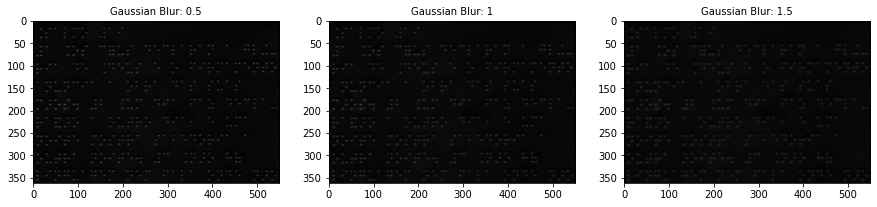

In [7]:
#Imagens filtradas antes do uso dos filtros e apenas com a binarização sem limiar: 

im_binarized = ~cv2.GaussianBlur(img_in, size, 0.5)
im_binarized2 = ~cv2.GaussianBlur(img_in, size, 1.0)
im_binarized3 = ~cv2.GaussianBlur(img_in, size, 1.5)
figure, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 10))
axs[0].set_title("Gaussian Blur: 0.5",fontsize= 10)
axs[0].imshow(im_binarized,vmin=im_out1.min(),vmax=im_out1.max())
axs[1].set_title("Gaussian Blur: 1",fontsize= 10)
axs[1].imshow(im_binarized2,vmin=im_out3.min(),vmax=im_out3.max())
axs[2].set_title("Gaussian Blur: 1.5",fontsize= 10)
axs[2].imshow(im_binarized3,vmin=im_out2.min(),vmax=im_out2.max())

# O filtro gaussiano pode ser usado antes de técnicas de segmentação, como a canny. 
# Fazendo assim, uma segmentação mais precisa.


#### Vamos agora para um exemplo mais percepitivel e prático do poder de segmentação do GaussianBlur com a Canny:


In [8]:
img_entrada = cv2.imread('images/Teste.JPG',0) #Recebendo imagem de entrada
img_entrada = cv2.cvtColor(img_entrada, cv2.COLOR_BGR2RGB) 

Text(0.5, 1.0, 'Imagem Canny sem gaussian')

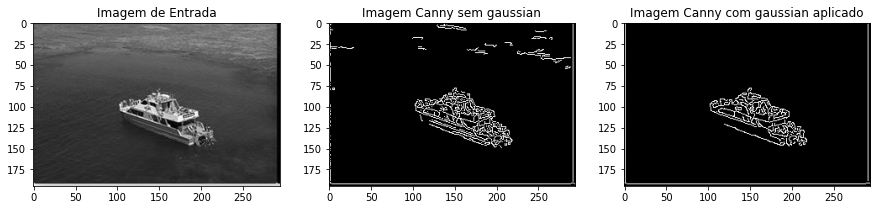

In [9]:
#aplicando filtro gaussiano na imagem de entrada:
nsize=3
size = (nsize,nsize)
img_blur = cv2.GaussianBlur(img_entrada, size, 1)
canny_output =  cv2.Canny(img_entrada, 90, 180, L2gradient = False )
canny_output2 = cv2.Canny(img_blur, 90, 180, L2gradient = False )

figure, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 10))
axs[0].imshow(img_entrada, cmap="gray")
axs[0].set_title("Imagem de Entrada",size = 12)
axs[2].imshow(canny_output2, cmap="gray")
axs[2].set_title("Imagem Canny com gaussian aplicado",size = 12)
axs[1].imshow(canny_output,cmap="gray")
axs[1].set_title("Imagem Canny sem gaussian",size = 12)

#### Também foi testado uma transforação de Furrier, mas teve um dos piores resultados do preprocessamento.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


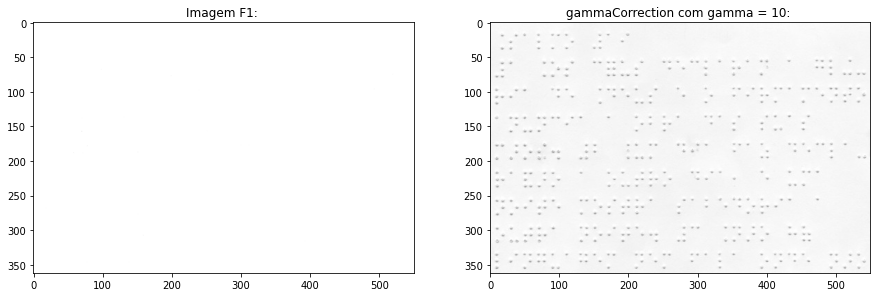

In [10]:
f = img_in


F1 = f.astype(np.int32)
F2 = f.astype(np.int32)

F1=2*F1-40

img_tranformada = cv2.intensity_transform.gammaCorrection(f,F2,10)

figure, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 10))
axs[0].set_title("Imagem F1: ",size =12)
axs[0].imshow(F1,vmin=F1.min(),vmax=F1.max())
axs[1].set_title("gammaCorrection com gamma = 10: ",size =12)
axs[1].imshow(F2,vmin=F2.min(),vmax=F2.max())


#### Com as imagens utilizando os filtros de gammacorrection no inicio, foi possível fazer dilatações e erosões para uma melhor segmentação e esses foram os resultados obtidos: 

In [11]:
W = 2
H = 2
R= 1
A = 1
kernel = cv2.getStructuringElement( cv2.MORPH_RECT, (W,H) )

dst_img2 = cv2.dilate( im_th3, kernel, iterations = 1 )

kernel2 = skimage.morphology.star( A)

dst_img3= cv2.dilate( im_th3, kernel2, iterations = 1 )
                                   
kernel3 = cv2.getStructuringElement( cv2.MORPH_CROSS, (W,H) )  
                                   
dst_img4= cv2.dilate( im_th3, kernel3, iterations = 1 )

kernel4 = skimage.morphology.disk( R )

dst_img5= cv2.dilate( im_th3, kernel4, iterations = 1 )

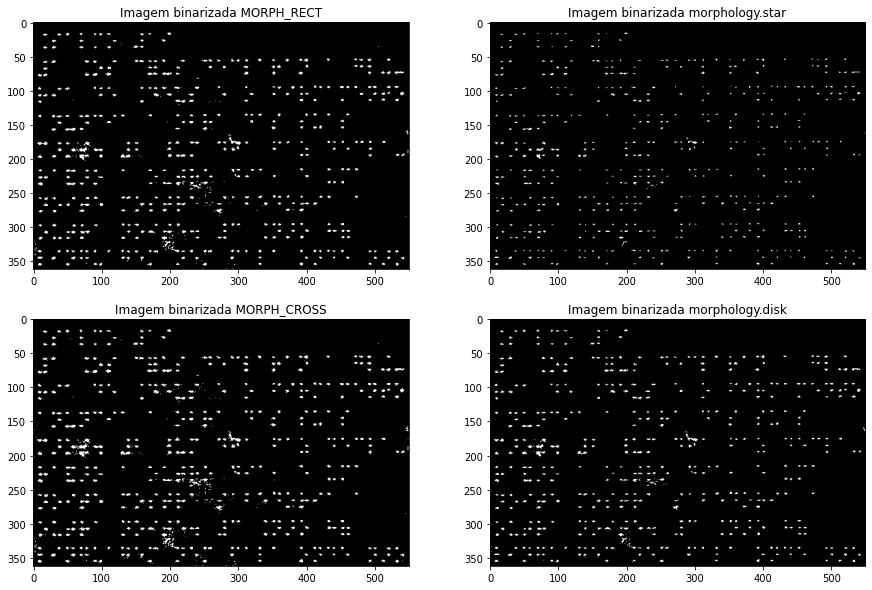

In [12]:
figure, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(15, 10))

axs[0,0].set_title("Imagem binarizada MORPH_RECT")
axs[0,0].imshow(~dst_img2,cmap="gray")
axs[0,1].set_title("Imagem binarizada morphology.star")
axs[0,1].imshow(~dst_img3,cmap="gray")
axs[1,0].set_title("Imagem binarizada MORPH_CROSS")
axs[1,0].imshow(~dst_img4,cmap="gray")
axs[1,1].set_title("Imagem binarizada morphology.disk")
axs[1,1].imshow(~dst_img5,cmap="gray")

#### Agora os mesmos procedimentos, mas com uma binarização sem limiarização: 


In [13]:
bin_img = ~img_in #Recebendo a imagem e binarizando


W = 2
H = 2
R= 1
A = 1
kernel = cv2.getStructuringElement( cv2.MORPH_RECT, (W,H) )

dst_img22 = cv2.dilate( bin_img, kernel, iterations = 1 )

kernel2 = skimage.morphology.star( A)

dst_img33= cv2.dilate( bin_img, kernel2, iterations = 1 )
                                   
kernel3 = cv2.getStructuringElement( cv2.MORPH_CROSS, (W,H) )  
                                   
dst_img44= cv2.dilate( bin_img, kernel3, iterations = 1 )

kernel4 = skimage.morphology.disk( R )

dst_img55= cv2.dilate( bin_img, kernel4, iterations = 1 )


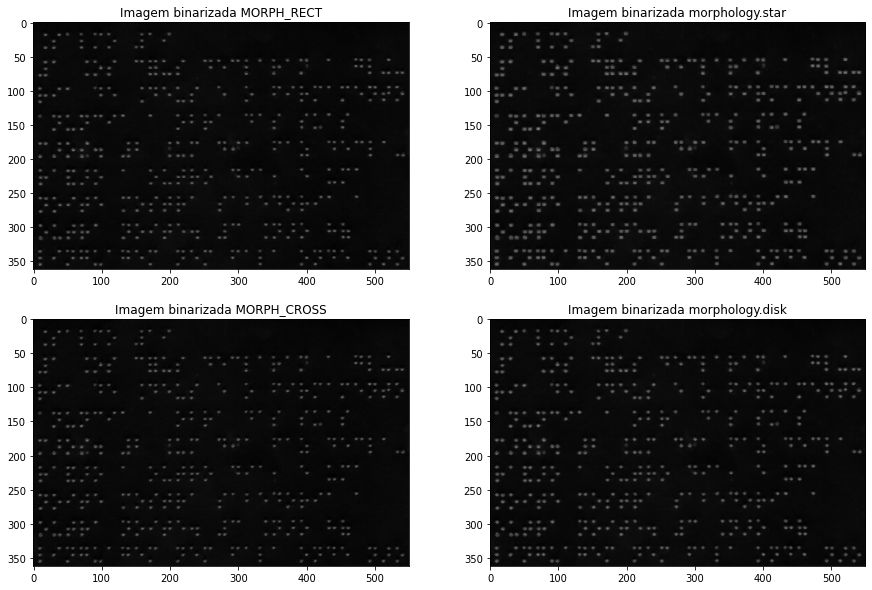

In [14]:
figure, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(15, 10))

axs[0,0].set_title("Imagem binarizada MORPH_RECT")
axs[0,0].imshow(dst_img22,cmap="gray")
axs[0,1].set_title("Imagem binarizada morphology.star")
axs[0,1].imshow(dst_img33,cmap="gray")
axs[1,0].set_title("Imagem binarizada MORPH_CROSS")
axs[1,0].imshow(dst_img44,cmap="gray")
axs[1,1].set_title("Imagem binarizada morphology.disk")
axs[1,1].imshow(dst_img55,cmap="gray")

#### Outra abordagem foi fazer abertura e fechamento com a imagem de entrada, onde podemos ter uma melhor visualização e qual caminho seguir. foi aqui que começamos a optar por alguns métodos mais eficientes de segmentação de objetos, principalmente com imagens de uma segmentação de apenas dois elementos, no nosso caso, os pontos e a folha.

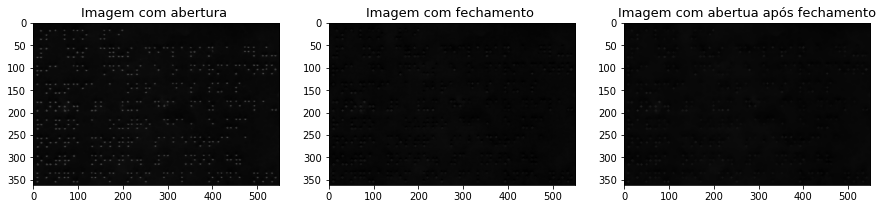

In [15]:
kernel = skimage.morphology.disk( 2)

dst_img_open = cv2.morphologyEx(img_in, cv2.MORPH_OPEN, kernel)

dst_img_close = cv2.morphologyEx(img_in, cv2.MORPH_CLOSE, kernel)

dst_img_open_after_close = cv2.morphologyEx(dst_img_close, cv2.MORPH_OPEN, kernel)

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 15))

axs[0].set_title("Imagem com abertura ",size = 13)
axs[0].imshow(~dst_img_open,vmin=0, vmax=1, cmap="gray")

axs[1].set_title("Imagem com fechamento ",size = 13)
axs[1].imshow(~dst_img_close,vmin=0, vmax=1, cmap="gray")

axs[2].set_title("Imagem com abertua após fechamento",size = 13)
axs[2].imshow(~dst_img_open_after_close,vmin=0, vmax=1, cmap="gray")


#### Até o momento, essa seguia sendo a melhor segmentação obtida e a mais eficiente.

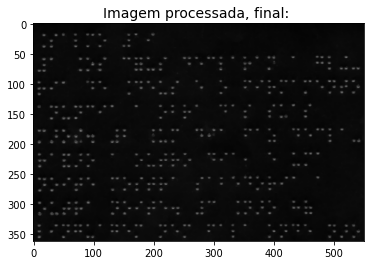

In [16]:
kernel = skimage.morphology.disk( 1.4)

img_final = cv2.dilate(~dst_img_open, kernel, iterations = 1 )

plt.title("Imagem processada, final: ",size = 14)
plt.imshow(img_final,vmin=0, vmax=1, cmap="gray")

#### Já foi mostrado uma aplicação do Canny e o seu poder computacional, mas foi aqui onde começamos a testar o Canny e o Sobel, e observamos um resultado realmente bom na segmentação dos caracteres, mas com um único problema, que é o vazio nos pontos encontrados, pois tanto o Sobel quanto o Canny segmentam a silhueta do elemento diferente do restante da imagem.

Text(0.5, 1.0, 'Detector de Canny')

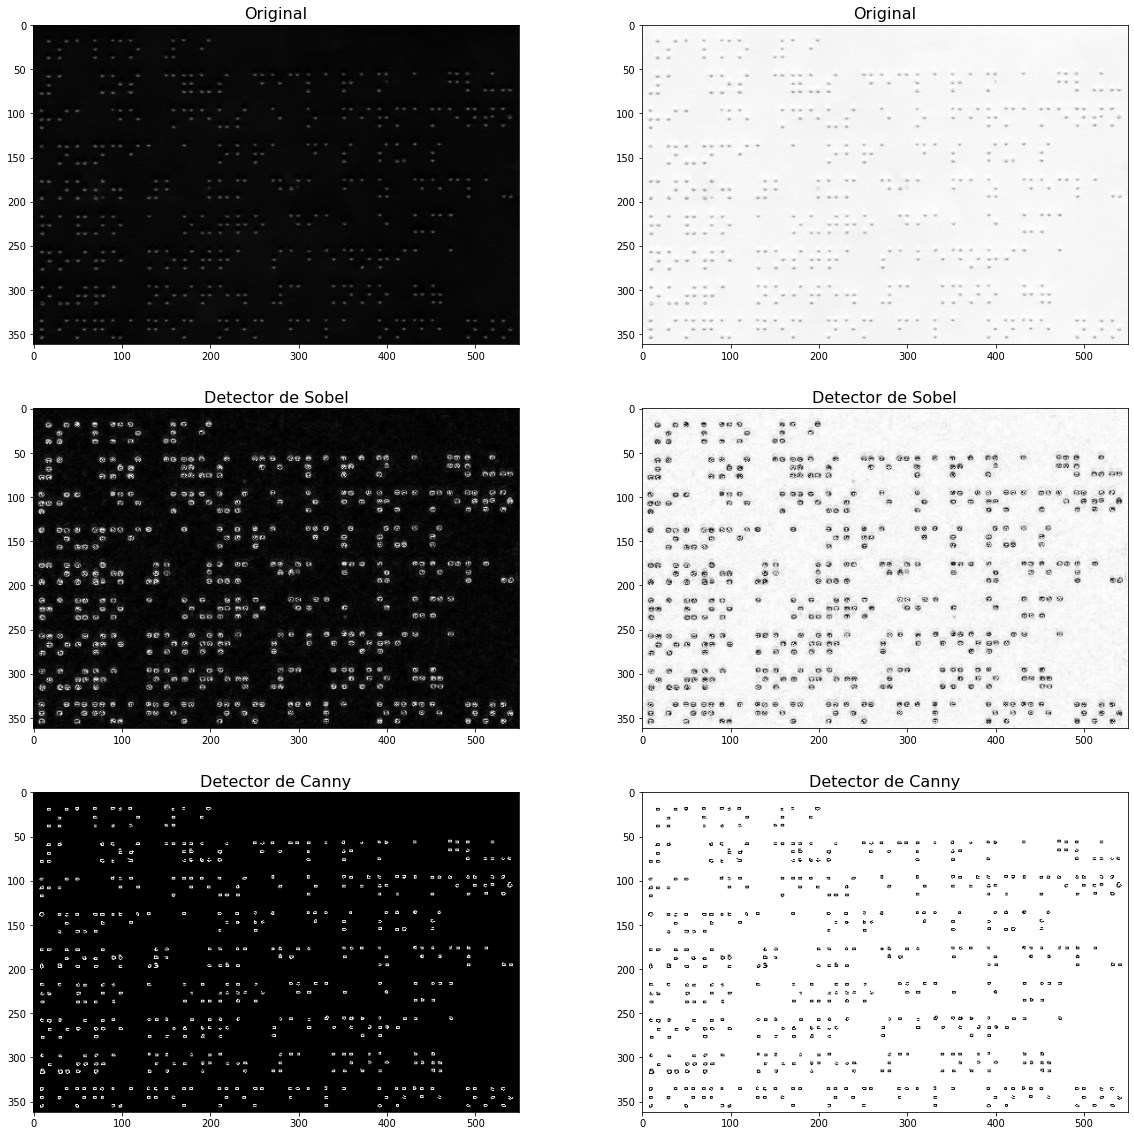

In [17]:
canny_output = cv2.Canny(img_in, 90, 180, L2gradient = True )
sobel_x = cv2.convertScaleAbs(cv2.Sobel(img_in, cv2.CV_16S, 1, 0, ksize=3))
sobel_y = cv2.convertScaleAbs(cv2.Sobel(img_in, cv2.CV_16S, 0, 1, ksize=3))
sobel_output = sobel_x + sobel_y

# Plots
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize=(20, 20))
    
# Imagem Original
axs[0,1].imshow(img_in, cmap="gray")
axs[0,1].set_title("Original", fontsize = 16)
axs[0,0].imshow(~img_in, cmap="gray")
axs[0,0].set_title("Original", fontsize = 16)

# Filtragem
axs[1,0].imshow(sobel_output, vmin = 0, vmax = 255, cmap="gray")
axs[1,0].set_title("Detector de Sobel", fontsize = 16)
axs[1,1].imshow(~sobel_output, vmin = 0, vmax = 255, cmap="gray")
axs[1,1].set_title("Detector de Sobel", fontsize = 16)

# Filtragem
axs[2,0].imshow(canny_output, vmin = 0, vmax = 255, cmap="gray")
axs[2,0].set_title("Detector de Canny", fontsize = 16)
axs[2,1].imshow(~canny_output, vmin = 0, vmax = 255, cmap="gray")
axs[2,1].set_title("Detector de Canny", fontsize = 16)

### Pré-processamento nas imagens de texto com vários caracteres
***

#### Aqui começamos a fazer as funções que poderiam ser usadas com base no estudo e observação de várias imagens

In [18]:
def preprocessing_sobel(img_in):
    '''
    Detecta as bordas da imagem utilizando o filtro sobrel

    Entrada:
    img_in -> array da imagem

    Saída:
    sobel_output -> imagem com as bordas detectadas

    '''
    
    sobel_x = cv2.convertScaleAbs(cv2.Sobel(img_in, cv2.CV_16S, 1, 0, ksize=3))
    sobel_y = cv2.convertScaleAbs(cv2.Sobel(img_in, cv2.CV_16S, 0, 1, ksize=3))
    sobel_output = sobel_x + sobel_y
    
    return ~sobel_output

In [19]:
def preprocessing_canny(img_in):
    '''
    Detecta as bordas da imagem utilizando o método de canny

    Entrada:
    img_in -> array da imagem

    Saída:
    dilatada_canny -> Imagem com as bordas detectadas
    '''
    
    canny_output = cv2.Canny(img_in, 90, 180, L2gradient = True )
    
    kernel = skimage.morphology.disk( 1)
    
    dilatada_canny = cv2.dilate(canny_output, kernel, iterations = 1 )
    
    return ~dilatada_canny

In [20]:
def opening_and_binarize(img_in):
    '''
    Realiza o processo de abertura e fechamento na imagem e a retorna binarizada

    Entrada:
    img_in -> Imagem armazenada em um array

    Saída:
    img_dilated_open_binarized -> Imagem pré-processada
    '''
    kernel = skimage.morphology.disk( 2)

    dst_img_open = cv2.morphologyEx(img_in, cv2.MORPH_OPEN, kernel)
    dst_img_close = cv2.morphologyEx(img_in, cv2.MORPH_CLOSE, kernel)
    
    kernel = skimage.morphology.disk(1.4)
    
    img_dilated_open_binarized= cv2.dilate(~dst_img_open, kernel, iterations = 1)

    for i in range(0, img_dilated_open_binarized.shape[0]):
        for j in range(0, img_dilated_open_binarized.shape[1]):
            if img_dilated_open_binarized[i][j] == 255:
                img_dilated_open_binarized[i][j] = 1
            else:
                img_dilated_open_binarized[i][j] = 0
    

    return ~img_dilated_open_binarized

In [21]:
preprocessada_canny = preprocessing_canny(img_in)
preprocessada_sobel = preprocessing_sobel(img_in)

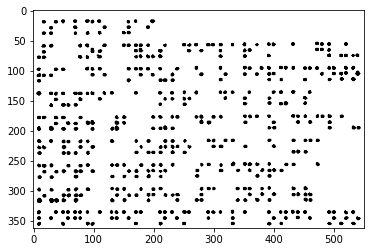

In [22]:
plt.imshow(preprocessada_canny, vmin=np.min(img_in), vmax=np.max(img_in),cmap = "gray")

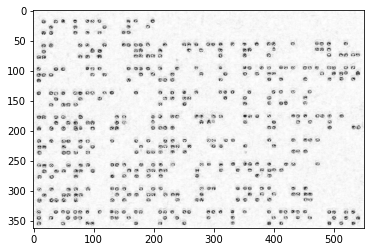

In [23]:
plt.imshow(preprocessada_sobel, vmin=np.min(img_in), vmax=np.max(img_in),cmap = "gray")

Text(0.5, 1.0, 'Detector de Canny + dilatação')

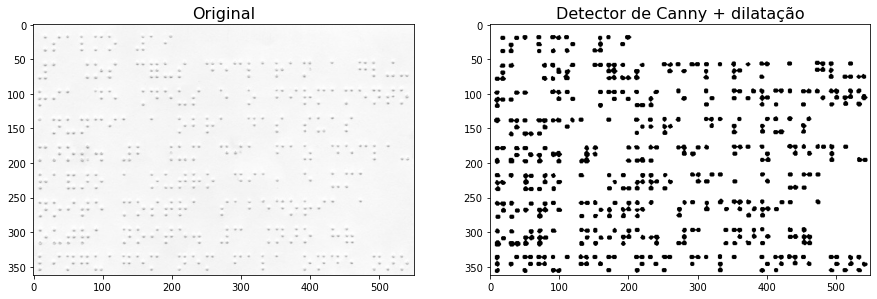

In [24]:
#Utilizando as noções aprendidas até então, foi aplicado o Detector de Canny com a Dilatação para o preenchimento dos pontos
#Funcionou com várias imagens, mas com algumas de qualidade inferior, não.
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 15))
    
axs[0].imshow(img_in, cmap="gray")
axs[0].set_title("Original", fontsize = 16)

axs[1].imshow(opening_and_binarize(preprocessada_canny), cmap="gray")
axs[1].set_title("Detector de Canny + dilatação", fontsize = 16)

Text(0.5, 1.0, 'Detector de Sobel + dilatação')

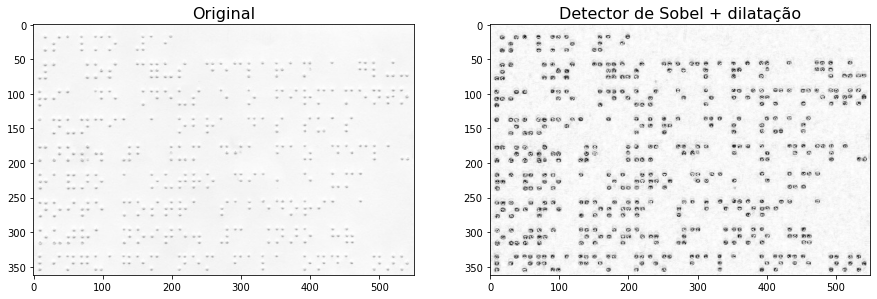

In [25]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 15))
    
axs[0].imshow(img_in, cmap="gray")
axs[0].set_title("Original", fontsize = 16)

axs[1].imshow(preprocessada_sobel, vmin = 0, vmax = 255, cmap="gray")
axs[1].set_title("Detector de Sobel + dilatação", fontsize = 16)

#### Foi preciso testar também a segmentação por OTSU e esses foram os resultados:

Text(0.5, 1.0, 'Binarização + Adaptive Tresh Gaussian')

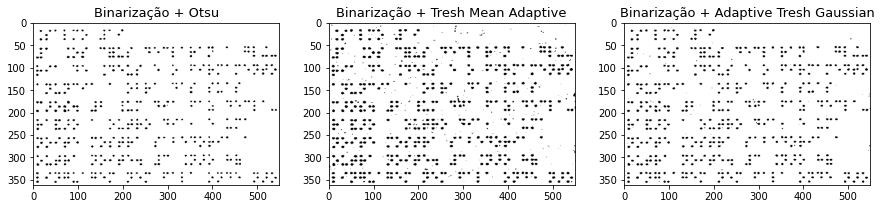

In [44]:
#img_in = cv2.imread('images/digitalizacao.jpeg',0 ) #Recebendo a imagem em grayescale
img_in = cv2.imread('images/digitalizacao.jpeg', cv2.IMREAD_GRAYSCALE)




img_in = cv2.GaussianBlur(img_in,(5,5),0)
hist = cv2.calcHist([img_in], [0], None, [256], [0,256])

limiar, th1 = cv2.threshold( img_in, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
th2 = cv2.adaptiveThreshold(img_in, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
th3 = cv2.adaptiveThreshold(img_in, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)


fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 15))
axs[0].imshow(th1,cmap= "gray")
axs[0].set_title("Binarização + Otsu",size = 13)
axs[1].imshow(th2,cmap= "gray")
axs[1].set_title("Binarização + Tresh Mean Adaptive",size = 13)
axs[2].imshow(th3,cmap= "gray")
axs[2].set_title("Binarização + Adaptive Tresh Gaussian",size = 13)

#### Podemos verificar um ruído na melhor imagem que obtivemos: a Binarização + Tresh Mean Adaptive. Portanto, vamos aplicar a mesma técnica comentada anteriormente com o uso do canny:

Text(0.5, 1.0, 'Binarização + Adaptive Tresh Gaussian')

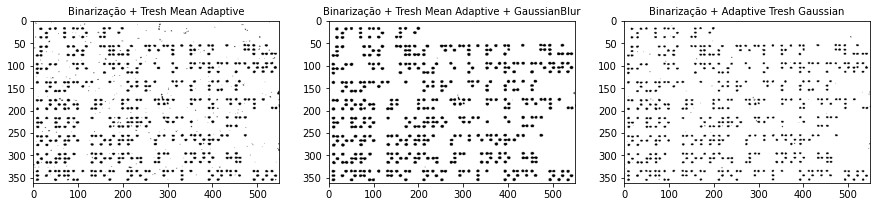

In [45]:
#Aplicando Gaussian Blur:
nsize=5
size = (nsize,nsize)
img_blur = cv2.GaussianBlur(img_in, size, 3.5)

th2_2 = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 15))
axs[0].imshow(th2,cmap= "gray")
axs[0].set_title("Binarização + Tresh Mean Adaptive",size = 10)
axs[1].imshow(th2_2,cmap= "gray")
axs[1].set_title("Binarização + Tresh Mean Adaptive + GaussianBlur",size = 10)
axs[2].imshow(th3,cmap= "gray")
axs[2].set_title("Binarização + Adaptive Tresh Gaussian",size = 10)

#### De mesmo modo, mas apenas exibindo em tons de fundo preto e pontos brancos:


Text(0.5, 1.0, 'Binarização + Adaptive Tresh Gaussian')

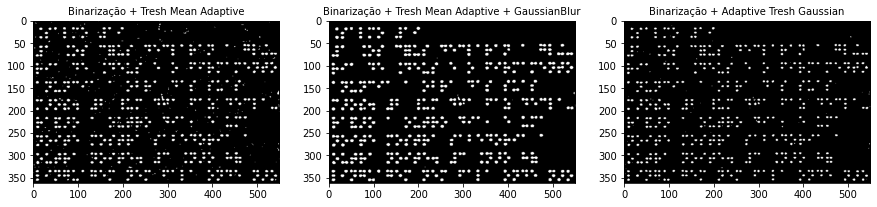

In [46]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 15))
axs[0].imshow(~th2,cmap= "gray")
axs[0].set_title("Binarização + Tresh Mean Adaptive",size = 10)
axs[1].imshow(~th2_2,cmap= "gray")
axs[1].set_title("Binarização + Tresh Mean Adaptive + GaussianBlur",size = 10)
axs[2].imshow(~th3,cmap= "gray")
axs[2].set_title("Binarização + Adaptive Tresh Gaussian",size = 10)

#### Após resultados satisfatórios, foi criada a função Tresh_Mean_and_Blur(), responsável pelo tratamento da maneira mais adequada até então.

In [65]:
def Tresh_Mean_and_Blur(img_in):
    ''' Recebe a imagem de entrada como parâmetro (img_in)
        Passa um filtro Gaussiano com kernel (5,5) e itensidade 3.5
        Por fim, é passado um AdaptativeThreshold juntamente com Thresh_Binary e Adaptative_Tresh_Mean
    '''
    #Aplicando Gaussian Blur:
    nsize=5
    size = (nsize,nsize)
    img_blur = cv2.GaussianBlur(img_in, size, 3.5)
    
    img_in = cv2.GaussianBlur(img_in,(5,5),0)
    hist = cv2.calcHist([img_in], [0], None, [256], [0,256])
    
    
    #Aplicando função de Treshold adaptativo:
    th2_2 = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    
    return ~th2_2


### Transformando a imagem em pixeis binarizados 0-1

In [47]:
from PIL import Image
import numpy as np
img = Image.open("images/digitalizacao.jpeg")

width = img.size[0] 
height = img.size[1] 

for i in range(0,width): #Processando todos os pixels na horizontal e na vertical
    for j in range(0,height):
        data = img.getpixel((i,j))  #incluindo os valores em data que recebe os pixels no canal RGB (canal 0,1 e 2)
        #print(data) #(255, 255, 255)
        if (data[0]==255 and data[1]==255 and data[2]==255):
            img.putpixel((i,j),(0, 0, 0))  #Incluindo
        else:
            
            img.putpixel((i,j),(255, 255, 255))
img.show()
img.save("Canny-binarizado.png")

In [48]:

img = Image.open("images/Canny.png")
grayImage = img.convert('L') #Convertendo a imagem para grayescale
binarizedImage = grayImage.point(lambda x: 0 if x==255 else 1)  
#verificando a imagem ponto a ponto, caso pixel seja 255, será trocado por 0, e caso contrario, para 1
                                                                
binarizedImage.save("binarized.png")

<IPython.core.display.Javascript object>


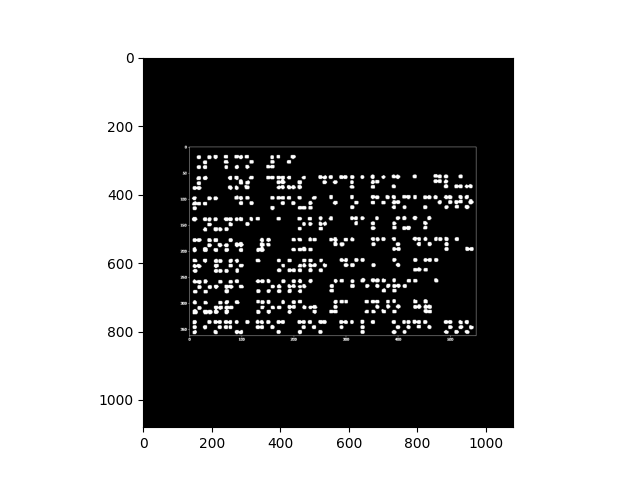

In [49]:

%matplotlib notebook
plt.imshow(binarizedImage, vmin=0 ,vmax=1, cmap="gray")

In [50]:
def Normalize_image(img):
    grayImage = img.convert('L') #Convertendo a imagem para grayescale
    binarizedImage = grayImage.point(lambda x: 0 if x==255 else 1)  
    #verificando a imagem ponto a ponto, caso pixel seja 255, será trocado por 0, e caso não seja, será trocado para 1
    return binarizedImage

In [66]:
img_normalizada = Normalize_image(img)

<IPython.core.display.Javascript object>


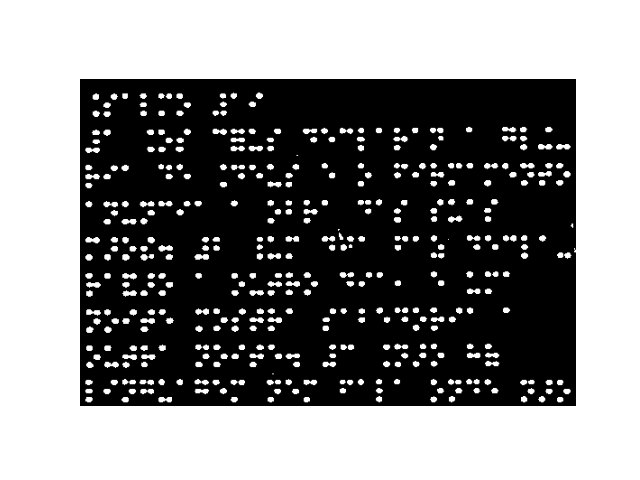

(-0.5, 549.5, 361.5, -0.5)

In [67]:
%matplotlib notebook
#outra forma de Normalizar a imagem em 0-1:
img_n = Tresh_Mean_and_Blur(img_in) /255
plt.imshow(img_n,cmap="gray")
plt.axis('off')

### Portanto, esses foram os resultados de preprocessamento da imagem de entrada que conseguimos, onde o melhores resultados foram: Canny, Thresh Mean Adaptative + Binarização e Otsu.  De modo geral, tivemos ótimos resultados com outros métodos, mas esses citados mostrasm melhor compatibilidade com todas as imagens testadas. 